## Table of Contents
1. Import Libraries
2. Import Data
3. Data Preprocessing
4. Quick EDA & Data Cleansing
    1. Date Features
    2. Categorical Features
    3. Numerical Features
5. Q1: Defining Next-Day Retention Rate
6. Q2: Evaluating a Hypothetical Claim
7. Q3: Investigating Metric Difference & Experimental Design
    1. Investigating Metric Difference
    2. Experimental Design

### Import Libraries <a name="import_libraries"></a>

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats as stats
import datetime as dt

### Import Data <a name="import_data"></a>

First let's import our data. We have two datasets to explore: **Users** and **Ratings**

In [3]:
# import users df
users = pd.read_csv('datingapp_data/users.csv')

# import ratings df
ratings = pd.read_csv('datingapp_data/ratings.csv')

In [4]:
# preview data in Users
print("Count of Unique Users:", len(users.user_id.unique())) # quick confirmation of # unique users

users.info() # note that some users contain nulls for certain features

Count of Unique Users: 111724
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111724 entries, 0 to 111723
Data columns (total 24 columns):
user_id                  111724 non-null int64
platform                 111724 non-null object
registration_ts          111724 non-null object
profile_completion_ts    111724 non-null object
gender                   111723 non-null float64
gender_preference        111574 non-null float64
photos_count             111724 non-null int64
max_distance             111624 non-null float64
metro_area               111724 non-null int64
age                      111724 non-null int64
age_pref_max             111622 non-null float64
age_pref_min             111622 non-null float64
age_strict               111621 non-null float64
height                   111713 non-null float64
height_pref_max          111591 non-null float64
height_pref_min          111591 non-null float64
height_strict            111591 non-null float64
education_attained       111722 non-n

In [5]:
# preview Users
users.head()

,user_id,platform,registration_ts,profile_completion_ts,gender,gender_preference,photos_count,max_distance,metro_area,age,...,height_pref_max,height_pref_min,height_strict,education_attained,dogs,cats,hobby1,hobby2,hobby3,hobby4
0,59758,Android,2018-10-19 11:46:12,2018-10-19 11:55:46,0.0,2.0,5,14.0,0,19,...,214.0,92.0,0.0,0.0,0.0,3.0,0,0,0,1
1,65302,iOS,2018-10-23 15:49:03,2018-10-23 15:57:18,1.0,0.0,5,40.0,2,34,...,214.0,180.0,1.0,0.0,2.0,0.0,0,0,0,1
2,91558,Android,2018-10-26 09:16:35,2018-10-26 09:21:13,0.0,1.0,5,50.0,57,23,...,184.0,166.0,0.0,0.0,2.0,3.0,0,0,0,0
3,203292,Android,2018-11-05 01:03:21,2018-11-05 01:09:34,0.0,1.0,5,63.0,0,28,...,214.0,92.0,0.0,3.0,2.0,1.0,0,0,0,1
4,222381,Android,2018-11-12 15:17:46,2018-11-12 15:19:52,0.0,1.0,5,100.0,0,25,...,214.0,92.0,0.0,3.0,0.0,3.0,0,0,0,1


In [6]:
# preview data in Ratings
print("Count of Unique Users in Ratings Table:", len(ratings.user_id.unique())) # quick confirmation of # unique users

ratings.info()

Count of Unique Users in Ratings Table: 110880
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18517862 entries, 0 to 18517861
Data columns (total 4 columns):
user_id        int64
rating_type    int64
ts_minute      object
ct             int64
dtypes: int64(3), object(1)
memory usage: 565.1+ MB


In [7]:
# preview Ratings
ratings.head()

,user_id,rating_type,ts_minute,ct
0,5100,1,2018-10-15 01:55:00,1
1,5088,1,2018-10-15 02:08:00,3
2,5095,0,2018-10-15 02:25:00,6
3,5095,1,2018-10-15 02:40:00,1
4,5095,0,2018-10-15 03:13:00,8


In [18]:
# confirm no nulls
ratings.isnull().values.any()

False

We have 111,724 unique app users in the `users` table and 110,880 are present in `ratings`. Presumably users whom are present in our `users` table but not in `ratings` are users who registered for the app but never performed any ratings...something we'll have to keep in mind for later.

### Data Preprocessing <a name="data_prep"></a>

Before getting into any analysis, let's ensure our data is cleaned and in proper shape. First let's fix some data types, particularly our datetime features.

In [19]:
# fix datetime features
users['registration_ts'] = pd.to_datetime(users['registration_ts'])
users['profile_completion_ts'] = pd.to_datetime(users['profile_completion_ts'])
ratings['ts_minute'] = pd.to_datetime(ratings['ts_minute'])

Let's now aggregate `ratings` to the user-date level as it doesn't appear like ratings granular to the minute will be useful in our analysis that follows. Aside from being easier to work with, this reduces the total records in `ratings` from 18.5M to 1.7M and will make subsequent joining less taxing.

In [20]:
# aggregate ratings to user-ratingtype-date level
ratings_agg = ratings.groupby([ratings.user_id, ratings.rating_type, ratings.ts_minute.dt.date]).sum().reset_index()

# quick column rename
ratings_agg = ratings_agg.rename(columns={'ts_minute':'ts_date'})
ratings_agg['ts_date'] = pd.to_datetime(ratings_agg['ts_date'])

ratings_agg

,user_id,rating_type,ts_date,ct
0,1,0,2018-10-20,31
1,1,0,2018-10-21,31
2,1,0,2018-10-23,9
3,1,0,2018-10-24,2
4,1,0,2018-10-25,96
...,...,...,...,...
1721083,248753,1,2018-11-12,5
1721084,248753,1,2018-11-13,1
1721085,248753,1,2018-11-14,1
1721086,248753,1,2018-11-15,2


Next, let's join our `users` table onto `ratings` so that we can understand how user-specific information might impact their rating behavior.

In [24]:
# perform an inner join on user_id (will return data for users present in both tables)
user_ratings = pd.merge(left = ratings_agg, 
                        right = users, 
                        how = 'inner', 
                        on = 'user_id')

# preview
user_ratings.head()

,user_id,rating_type,ts_date,ct,platform,registration_ts,profile_completion_ts,gender,gender_preference,photos_count,...,height_pref_max,height_pref_min,height_strict,education_attained,dogs,cats,hobby1,hobby2,hobby3,hobby4
0,1,0,2018-10-20,31,iOS,2018-10-20 01:43:20,2018-10-20 01:51:04,0.0,1.0,5,...,214.0,92.0,0.0,1.0,2.0,0.0,0,0,0,1
1,1,0,2018-10-21,31,iOS,2018-10-20 01:43:20,2018-10-20 01:51:04,0.0,1.0,5,...,214.0,92.0,0.0,1.0,2.0,0.0,0,0,0,1
2,1,0,2018-10-23,9,iOS,2018-10-20 01:43:20,2018-10-20 01:51:04,0.0,1.0,5,...,214.0,92.0,0.0,1.0,2.0,0.0,0,0,0,1
3,1,0,2018-10-24,2,iOS,2018-10-20 01:43:20,2018-10-20 01:51:04,0.0,1.0,5,...,214.0,92.0,0.0,1.0,2.0,0.0,0,0,0,1
4,1,0,2018-10-25,96,iOS,2018-10-20 01:43:20,2018-10-20 01:51:04,0.0,1.0,5,...,214.0,92.0,0.0,1.0,2.0,0.0,0,0,0,1


### Quick EDA & Data Cleansing <a name="eda"></a>

Before moving on with our joint dataset, let's quickly explore our features to get a high-level understanding of what we're working with and to see if there's any additional data cleaning required.

#### Date Features <a name="dates"></a>

Our data contains records for users who registered over a 1-month period from `2018-10-15` to `2018-11-14`, along with accompanying ratings data spanning from `2018-10-15` to `2018-11-17`.

In [11]:
print("Timeframe of User Registrations:", user_ratings['registration_ts'].min(), "-", user_ratings['registration_ts'].max())

print("Timeframe of User Ratings:", user_ratings['ts_date'].min(), "-", user_ratings['ts_date'].max())

Timeframe of User Registrations: 2018-10-15 00:00:48 - 2018-11-14 23:59:14
Timeframe of User Ratings: 2018-10-15 00:00:00 - 2018-11-17 00:00:00


#### Categorical Features <a name="cats"></a>

Let's take a look at `platform`:

Android    1046255
iOS         668512
ios           6192
Name: platform, dtype: int64

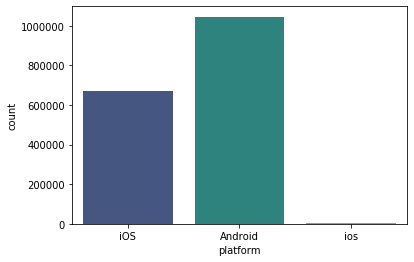

In [12]:
# let's explore platform
sns.countplot(user_ratings['platform'], palette = 'viridis')

user_ratings['platform'].value_counts()

We find that some users have been classified as "ios" instead of "iOS". Let's consolidate this...

In [13]:
users = users.assign(platform = ['iOS' if platform == 'ios' else platform for platform in users['platform']])
user_ratings = user_ratings.assign(platform = ['iOS' if platform == 'ios' else platform for platform in user_ratings['platform']])

user_ratings['platform'].value_counts() # updated

Android    1046255
iOS         674704
Name: platform, dtype: int64

We continue exploring a few other features but don't find anything too alarming. A few quick-hitter findings are listed below:

- About `59.4%` of users are of `Gender 0`
- Nearly a quarter (`23.6%`) of users are from a single city (`City 0`), while the top 5 cities represent just over half (`51.5%`) our users
- `87.9%` of users wish to *only* consider users that fall within their stated age preference
- Just `18.0%` of users wish to *only* consider users that fall within their stated height preference
- `44.8%` of users completed up to `Education 1` (note that levels are not ordinal)

In [14]:
# quick exploration of other categorical features
    # user gender
display(users['gender'].value_counts(normalize = True))

    # metro area
display(users['metro_area'].value_counts(normalize = True))

    # age deal-breaker
display(users['age_strict'].value_counts(normalize = True))

    # height deal-breaker
display(users['height_strict'].value_counts(normalize = True))

    # education attained
display(users['education_attained'].value_counts(normalize = True))

0.0    0.59379
1.0    0.40621
Name: gender, dtype: float64

0     0.235634
39    0.100381
27    0.083035
28    0.054876
6     0.040752
        ...   
73    0.000009
74    0.000009
65    0.000009
77    0.000009
62    0.000009
Name: metro_area, Length: 73, dtype: float64

1.0    0.879386
0.0    0.120614
Name: age_strict, dtype: float64

0.0    0.819869
1.0    0.180131
Name: height_strict, dtype: float64

1.0    0.448417
2.0    0.223206
3.0    0.200354
0.0    0.128023
Name: education_attained, dtype: float64

#### Numerical Features <a name="nums"></a>

Once again, some quick observations listed below:

- Median user age is `26` (note distribution is right skewed due to extreme outlier)
- On average users have `4.9` uploaded photos
- Average max distance a user is willing to consider is `57.3` miles, though `100` miles is the distance most frequently specified
- Average preferred age range is `23 - 37`
- App users seem to prefer cats over dogs!

In [15]:
# summary stats for user-specific numerical features
user_numerics = users[['photos_count','max_distance','age','age_pref_max','age_pref_min',
                       'height','height_pref_max','height_pref_min','dogs','cats']]

user_numerics.describe() # note missing values for a few vars

,photos_count,max_distance,age,age_pref_max,age_pref_min,height,height_pref_max,height_pref_min,dogs,cats
count,111724.000000,111624.000000,111724.000000,111622.000000,111622.000000,111713.000000,111591.000000,111591.000000,111722.000000,103985.000000
mean,4.924331,57.275792,27.611883,37.350406,23.196153,173.607217,207.576937,118.727218,1.092909,2.294139
std,0.718974,38.704596,7.225031,12.128034,5.779914,10.019123,14.018628,36.740848,1.063952,0.920269
min,0.000000,0.000000,18.000000,18.000000,18.000000,92.000000,92.000000,92.000000,0.000000,0.000000
25%,5.000000,20.000000,23.000000,29.000000,19.000000,165.000000,214.000000,92.000000,0.000000,2.000000
50%,5.000000,50.000000,26.000000,34.000000,22.000000,173.000000,214.000000,92.000000,1.000000,3.000000
75%,5.000000,100.000000,30.000000,42.000000,26.000000,180.000000,214.000000,159.000000,2.000000,3.000000
max,9.000000,100.000000,581.000000,65.000000,65.000000,213.000000,214.000000,214.000000,3.000000,3.000000


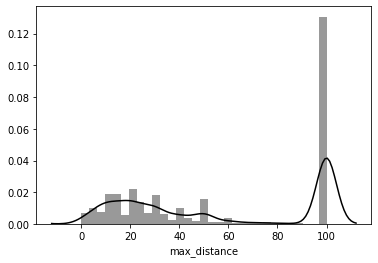

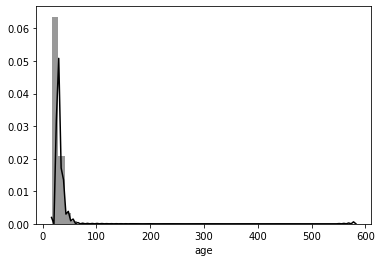

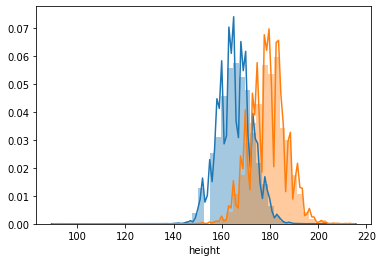

In [16]:
# quick viz of a few user-specific numerical features
    # max distance
sns.distplot(users['max_distance'].dropna(), color = "black")
plt.show()

    # user age
sns.distplot(users['age'], color = "black")
plt.show() # note extreme outlier 581

    # user height
sns.distplot(users[users['gender'] == 1]['height'].dropna()) # blue (likely female)
sns.distplot(users[users['gender'] == 0]['height'].dropna()) # orange (likely male)
plt.show()

Finally, let's also take a quick look at our `ct` variable to get some insight into user rating behavior.

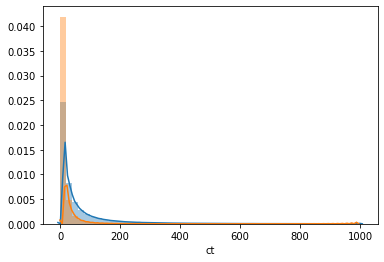

,rating_type,ct
0,0,21
1,1,5


In [17]:
# here we're plotting the avg daily ratings given per user by rating type (like or skip)
    # we'll filter extreme outliers from the plot for viz purposes (note extreme right skewness, uber active users)
sns.distplot(user_ratings[(user_ratings['rating_type'] == 0) & (user_ratings['ct'] < 1000)]['ct'].dropna()) # blue (skips)
sns.distplot(user_ratings[(user_ratings['rating_type'] == 1) & (user_ratings['ct'] < 1000)]['ct'].dropna()) # orange (likes)
plt.show()

# aggregate the median # of daily ratings given per user by rating type (like or skip)
by_rating_type = user_ratings.groupby(['rating_type'])['ct'].median().reset_index()
by_rating_type

We observe that the typical app user gives about `5` likes per day and `21` skips. This works out to roughly a `1:4` ratio between likes vs skips for the average user on a given day (i.e., 4 skips for every like).

### Q1) Defining Next-Day Retention Rate <a name="q1"></a>

**Using the data available, how would you define next-day retention rate of new users? State your definition in a way that someone else can compute the metric unambiguously.**

In order to define our *next-day retention rate* metric, there are a couple assumptions we must specify upfront.

1) The first thing to note is that we're seeking to evaluate this metric for **new users**. We'll define a user as being *new* based on when they **first registered for the app**, hence we'll use `registration_ts` to mark a user's first official day on the app.

2) Next, we must determine what qualifies as *successful* retention. *Retention* implies that the user is returning to the app and continuing their activity on the app in some fashion. Considering the data we have at our disposal, I think it's most reasonable for us to define someone being **active** on the app when they have **any rating activity (i.e., at least 1 skip or like) that day**. 

While I believe this is reasonable, note that there are several ways we could have tinkered our definition of *active*:
- User performed some other action on the app (e.g., logging on, profile edits, etc.)...we don't have this data in this scenario
- User sent a like (i.e., only `rating_type = 1`)
- User reached some threshold for minimum ratings (e.g., at least 10 total ratings given)

<br>

With these assumptions stated, we can define our `next-day retention rate` as the simple proportion that follows:

<br>

<center><i> # of users active the day after registration / # of new users </i></center>

Let's now go ahead with computing our metric.

In [18]:
## STEP 1: let's identify each user's first active date POST-registration

    # filter out cases where rating activity occurs on date of registration
user_ratings_filt = user_ratings[user_ratings.ts_date != user_ratings.registration_ts.dt.date][['user_id','ts_date']]

    # now let's aggregate by user, only keeping their earliest ratings ts_date (post_registration)
post_reg_activity = user_ratings_filt.loc[user_ratings_filt.groupby('user_id')['ts_date'].idxmin()]

    # rename column accordingly
post_reg_activity = post_reg_activity.rename(columns={'ts_date':'post_reg_active'})
        # note that rating type doesn't matter in the calculation of our metric; we simply want a single record
        # per user with their earliest post-registration 'active' date (regardless of the rating type)

    # preview
post_reg_activity
    # observe that we've obtained a single line per user

,user_id,post_reg_active
1,1,2018-10-21
49,3,2018-11-14
57,4,2018-10-25
72,5,2018-11-15
80,7,2018-10-30
...,...,...
1720810,248740,2018-11-08
1720830,248741,2018-11-08
1720844,248746,2018-10-24
1720877,248748,2018-10-22


Now, it's critical to remember that there are two general cases a customer can fall into:

1. User is only active on the app the day they register and never return
2. User returns at some point after their registration date
    
Step 1 above **only** evaluates `post_reg_active` date for users who used the app after their registration date (case 2). We still must consider our case 1 users...

In [19]:
## STEP 2: let's now join our post_reg_activity df to our original users df (which contains registration date)

    # pivotal to use a left join here - this ensures that users who were ONLY active on the same day they registered 
        # get tagged with a NULL post_reg_active date
users_final = pd.merge(left = users, 
                  right = post_reg_activity,
                  on = 'user_id',
                  how = 'left')

    #preview
users_final

,user_id,platform,registration_ts,profile_completion_ts,gender,gender_preference,photos_count,max_distance,metro_area,age,...,height_pref_min,height_strict,education_attained,dogs,cats,hobby1,hobby2,hobby3,hobby4,post_reg_active
0,59758,Android,2018-10-19 11:46:12,2018-10-19 11:55:46,0.0,2.0,5,14.0,0,19,...,92.0,0.0,0.0,0.0,3.0,0,0,0,1,2018-10-20
1,65302,iOS,2018-10-23 15:49:03,2018-10-23 15:57:18,1.0,0.0,5,40.0,2,34,...,180.0,1.0,0.0,2.0,0.0,0,0,0,1,2018-10-24
2,91558,Android,2018-10-26 09:16:35,2018-10-26 09:21:13,0.0,1.0,5,50.0,57,23,...,166.0,0.0,0.0,2.0,3.0,0,0,0,0,2018-10-27
3,203292,Android,2018-11-05 01:03:21,2018-11-05 01:09:34,0.0,1.0,5,63.0,0,28,...,92.0,0.0,3.0,2.0,1.0,0,0,0,1,2018-11-06
4,222381,Android,2018-11-12 15:17:46,2018-11-12 15:19:52,0.0,1.0,5,100.0,0,25,...,92.0,0.0,3.0,0.0,3.0,0,0,0,1,2018-11-14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111719,246795,iOS,2018-11-14 02:01:27,2018-11-14 02:07:41,1.0,0.0,5,29.0,39,25,...,177.0,1.0,3.0,2.0,3.0,0,0,0,1,2018-11-15
111720,99908,Android,2018-10-31 21:59:52,2018-10-31 22:00:01,0.0,1.0,5,100.0,27,20,...,92.0,0.0,1.0,1.0,3.0,0,0,0,0,2018-11-01
111721,166198,Android,2018-10-27 11:09:41,2018-10-27 11:11:20,1.0,0.0,5,100.0,0,22,...,92.0,0.0,3.0,0.0,2.0,0,0,0,1,2018-10-28
111722,238222,Android,2018-11-11 17:22:36,2018-11-11 17:27:36,1.0,0.0,5,100.0,2,22,...,92.0,0.0,1.0,2.0,3.0,0,0,0,1,2018-11-12


Beautiful! Now we have our `post_reg_active` date appended to each of our `111,724` unique app users.

In [20]:
## STEP 3) let's compute a datediff field taking the difference between a user's registration and their subsequent active date

    # calculate the difference
users_final['delta_days'] = (users_final.post_reg_active - pd.to_datetime(users_final.registration_ts.dt.date)).dt.days

    # preview
users_final[['user_id', 'registration_ts', 'post_reg_active', 'delta_days']].head()
    # observe our delta_days variable

,user_id,registration_ts,post_reg_active,delta_days
0,59758,2018-10-19 11:46:12,2018-10-20,1.0
1,65302,2018-10-23 15:49:03,2018-10-24,1.0
2,91558,2018-10-26 09:16:35,2018-10-27,1.0
3,203292,2018-11-05 01:03:21,2018-11-06,1.0
4,222381,2018-11-12 15:17:46,2018-11-14,2.0


In [21]:
## STEP 4) let's implement some logic to calculate our metric:
    
    # create quick function
def retention(users_final):
    if users_final['delta_days'] == 1: # i.e., iff active one day after registration then user was retained
        return 1
    return 0
    
    # apply our function
users_final['retention_rate'] = users_final.apply(retention, axis=1)

    # preview
users_final[['user_id', 'registration_ts', 'post_reg_active', 'delta_days', 'retention_rate']]

,user_id,registration_ts,post_reg_active,delta_days,retention_rate
0,59758,2018-10-19 11:46:12,2018-10-20,1.0,1
1,65302,2018-10-23 15:49:03,2018-10-24,1.0,1
2,91558,2018-10-26 09:16:35,2018-10-27,1.0,1
3,203292,2018-11-05 01:03:21,2018-11-06,1.0,1
4,222381,2018-11-12 15:17:46,2018-11-14,2.0,0
...,...,...,...,...,...
111719,246795,2018-11-14 02:01:27,2018-11-15,1.0,1
111720,99908,2018-10-31 21:59:52,2018-11-01,1.0,1
111721,166198,2018-10-27 11:09:41,2018-10-28,1.0,1
111722,238222,2018-11-11 17:22:36,2018-11-12,1.0,1


And there we have the computation of our `retention rate` metric for all `111,724` users we have user data on.

Let's zoom into a few specific user sub-cases just to ensure things are looking good.

- `User 3`: User was active on the app the day after their registration date
- `User 6`: User was only active on the app the day they registered
- `User 657`: User was first active on the app the day after they registered
- `User 82031`: User registered but never was active on the app (at least in the data we have)
- `User 222381`: User was active on the app after their registration date, but not on the very next day

For context, before our manipulation the data for these users looked like this:

In [22]:
user_ratings[user_ratings.user_id.isin([3,6,657,82031,222381])][['user_id','rating_type','ts_date','platform','registration_ts']].sort_values(['user_id','ts_date'])

    # note that User 82031 doesn't even appear here as they had no ratings data recorded

,user_id,rating_type,ts_date,platform,registration_ts
48,3,0,2018-11-13,Android,2018-11-13 06:38:34
52,3,1,2018-11-13,Android,2018-11-13 06:38:34
49,3,0,2018-11-14,Android,2018-11-13 06:38:34
53,3,1,2018-11-14,Android,2018-11-13 06:38:34
50,3,0,2018-11-15,Android,2018-11-13 06:38:34
54,3,1,2018-11-15,Android,2018-11-13 06:38:34
51,3,0,2018-11-16,Android,2018-11-13 06:38:34
55,3,1,2018-11-16,Android,2018-11-13 06:38:34
77,6,0,2018-10-17,Android,2018-10-17 04:22:29
78,6,1,2018-10-17,Android,2018-10-17 04:22:29


Now, we've obtained this:

In [23]:
# examine user sub-cases
users_final[users_final.user_id.isin([3,6,657,82031,222381])][['user_id','platform','registration_ts','post_reg_active','delta_days','retention_rate']].sort_values('user_id')

,user_id,platform,registration_ts,post_reg_active,delta_days,retention_rate
65544,3,Android,2018-11-13 06:38:34,2018-11-14,1.0,1
48275,6,Android,2018-10-17 04:22:29,NaT,NaN,0
96343,657,iOS,2018-10-18 23:54:04,2018-10-19,1.0,1
567,82031,iOS,2018-10-19 00:32:30,NaT,NaN,0
4,222381,Android,2018-11-12 15:17:46,2018-11-14,2.0,0


### Q2) Evaluating a Hypothetical Claim <a name="q2"></a>

**There is a claim stating that retention rates of Android and iOS users are different. Does the data support this claim? Is the retention rate of users on one platform consistently lower than that of the other?**

We can quickly see that our overall retention rate (across all users over our timeframe) is **`76.6%`**.

In [24]:
# compute overall mean retention rate
users_final['retention_rate'].mean()

0.7661200816297304

Just out of curiosity, let's take a quick look at the distribution of our `delta_days` variable to understand how soon after their registration date returning app users are active.

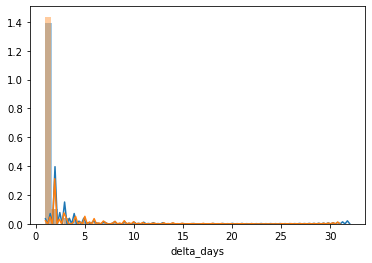

In [25]:
# plot delta_days distribution
sns.distplot(users_final[users_final['platform'] == 'iOS']['delta_days']) # blue
sns.distplot(users_final[users_final['platform'] == 'Android']['delta_days']) # orange

Now to explore the claim, let's evaluate the **average daily retention rate between platforms** to see how they compare and if one is *consistently* lower than the other on a daily basis.

In [26]:
# aggregate avg retention rate by platform
display(users_final.groupby('platform')['retention_rate'].mean().reset_index())

# also aggregate avg retention rate at a platform & registration date level
retention_daily_agg = users_final.groupby([users_final.platform, users_final.registration_ts.dt.date])['retention_rate'].mean().reset_index()

    # preview
retention_daily_agg

,platform,retention_rate
0,Android,0.771335
1,iOS,0.758239


,platform,registration_ts,retention_rate
0,Android,2018-10-15,0.764477
1,Android,2018-10-16,0.760814
2,Android,2018-10-17,0.765272
3,Android,2018-10-18,0.770979
4,Android,2018-10-19,0.762045
...,...,...,...
57,iOS,2018-11-10,0.750678
58,iOS,2018-11-11,0.752252
59,iOS,2018-11-12,0.741353
60,iOS,2018-11-13,0.757637


We see that the average next-day retention rate for new users on Android is `77.1%`, while it's `75.8%` for new users on iOS. 

In order to evaluate whether iOS users *consistently* have a lower retention rate, we can take a look at the average retention rate on a daily basis.

C:\Users\ianno\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


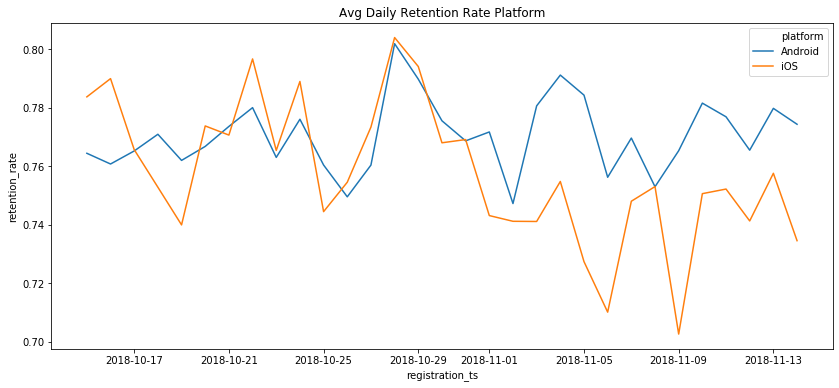

In [27]:
# plot a time series of avg daily retention rate by platform
plt.figure(figsize=(14,6))

sns.lineplot(x = retention_daily_agg['registration_ts'],
             y = retention_daily_agg['retention_rate'],
             hue = retention_daily_agg['platform']).set(title='Avg Daily Retention Rate Platform')

plt.show()

Here we observe that retention rate is rather even over the first two weeks, but then retention rate for iOS users does in fact become consistently lower than that of Android users starting in November. It does look like the claim holds some validility, at least in the most recent 2 weeks of data that we have.

To take this to a slightly more rigorous level, we can also perform some testing to see if there actually exists a statistically significant difference in retention rate between platforms.

Note that each user record we have at our disposal is effectively a Bernoulli trial - they either used the app on the day after registration (i.e., retained = 1) or they did not.

We'll perform a **two-sided test on our retention rate proportions**. We can summarize our null and alternative hypotheses as follows:

$$
  H_O: {retention}_{iOS} = {retention}_{Android}\\
  H_A: {retention}_{iOS} \neq {retention}_{Android}
$$

We also know that our sample `n = 111,724` and `Pr(retention) = 0.766`.

$$
np > 10\\
(111,724)(0.766) > 10\\
85,581 > 10
$$

$$
n(1-p) > 10\\
(111,724)(0.234) > 10\\
26,143 > 10
$$

This easily satisfies the conditions to assume normality through the central limit theorem (CLT). As a result, we can go the z-test route.

In [28]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

ios_users = users_final[users_final.platform == 'iOS']['retention_rate'] # ios user results
android_users = users_final[users_final.platform == 'Android']['retention_rate'] # android user results

n_ios = ios_users.count() #count of ios users
n_android = android_users.count() #count of android users
successes = [ios_users.sum(), android_users.sum()]
n_obs = [n_ios, n_android]

# two-sided stat test
z_stat, pval = proportions_ztest(count = successes,
                                 nobs = n_obs,
                                 alternative = 'two-sided') # recall our null/alt hyp above

# generate 95% confidence intervals for each platform
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(count = successes,
                  nobs = n_obs,
                  alpha = 0.05)

print(f'z-score: {z_stat:.3f}')
print(f'p-value: {pval:.4f}')
print(f'ci 95% for iOS users: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for Android users: [{lower_treat:.3f}, {upper_treat:.3f}]')

z-score: -5.062
p-value: 0.0000
ci 95% for iOS users: [0.754, 0.762]
ci 95% for Android users: [0.768, 0.775]


We easily reject the null hypothesis (`p-val ~ 0`) and conclude that there is indeed a significant difference in retention rates between iOS and Android users. This provides further evidence backing the claim being made.

### Q3) Investigating Metric Difference & Experimental Design <a name="q3"></a>

<b> If Android/iOS user retention rates are different, </b>
1. <b> What insights can you mine from the data that may be relevant to explaining the difference? </b>
2. <b> State a hypothesis about why Android and iOS users have different retention rates, and design an experiment to test 
    your hypothesis. </b>

#### Investigating Metric Difference <a name="q3a"></a>

Recall how we leveraged time series data in our Average Daily Retention Rate plot to see how iOS retention rate declined (and was consistently below) Android retention rate starting in November.

There are a few high-level possibilities that could explain the difference:
- User rating behavior differs between platforms
- There exists some notable difference in user demographics between platforms
- Some external factor impacted one platform and not the other at a particular point in time
    - Referring to our daily retention rate plot, maybe some external factor impacted only iOS users causing the drop (e.g., more bot profiles created on iOS at the start of Nov, a new competing app only available on Apple products is introduced)
- Some internal factor impacted the data generation process on one platform and not the other (e.g., bug fix, new feature launch)
    
Let's do some exploratory data analysis into some of the data points we've captured.

<u> New Users </u>

Let's first take a look at how many new users registered for the app each day:

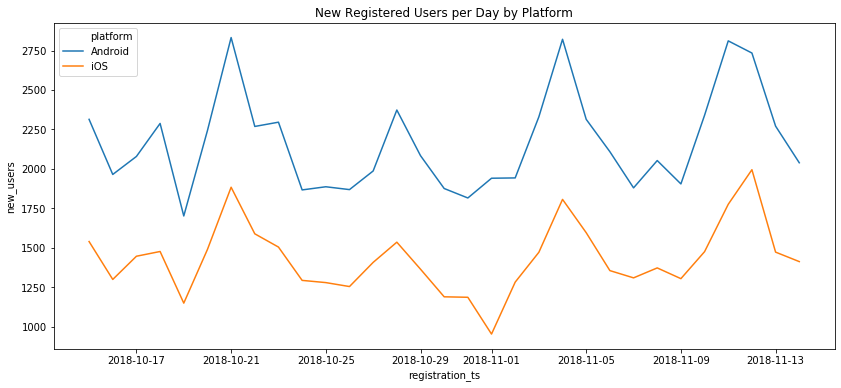

In [29]:
# let's explore new users
new_users_by_platform = users_final.groupby([users_final.registration_ts.dt.date,users_final.platform])['user_id'].nunique().reset_index()

plt.figure(figsize=(14,6))

sns.lineplot(x = new_users_by_platform['registration_ts'],
             y = new_users_by_platform['user_id'],
             hue = new_users_by_platform['platform']).set(title='New Registered Users per Day by Platform', ylabel = 'new_users')

plt.show()

Note that both platforms are nearly perfectly symmetrical, though there are more Android users joining overall.

<u> General Rating Behavior </u>

Let's explore general rating behavior:

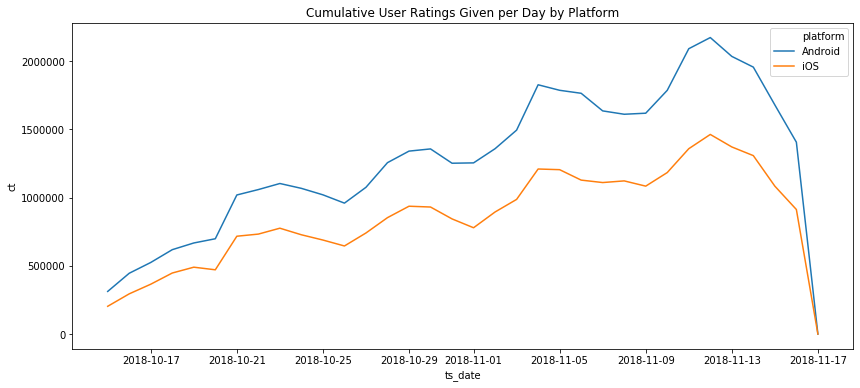

In [30]:
# let's explore general rating behavior
ratings_by_platform = user_ratings.groupby(['ts_date','platform'])['ct'].sum().reset_index()

plt.figure(figsize=(14,6))

sns.lineplot(x = ratings_by_platform['ts_date'],
             y = ratings_by_platform['ct'],
             hue = ratings_by_platform['platform']).set(title='Cumulative User Ratings Given per Day by Platform')

plt.show()
    # disregard dip on final date - data was only captured partially through Nov 17th

We observe nothing too peculiar...aggregate ratings show steady, symmetric growth on both platforms (as more users join). Also note that there are more users on Android, hence why the blue line is higher.

<u> Granular Rating Behavior - User Likes </u>

Let's also explore, in particular, how many likes are given out on average by users on each platform. Maybe users on one platform are giving more likes which could lead to more matches being made --> people being more content with the app --> better retention?

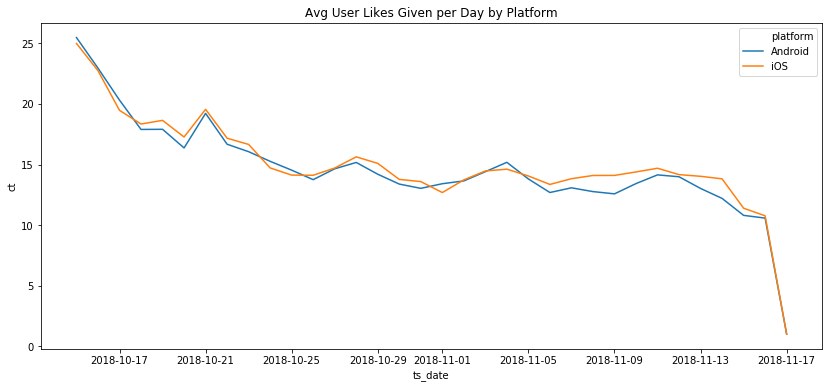

In [31]:
# how many likes are given out on avg by users on each platform
likes_by_platform = user_ratings[user_ratings['rating_type'] == 1].groupby(['ts_date','platform'])['ct'].mean().reset_index()

plt.figure(figsize=(14,6))

sns.lineplot(x = likes_by_platform['ts_date'],
             y = likes_by_platform['ct'],
             hue = likes_by_platform['platform']).set(title='Avg User Likes Given per Day by Platform')

plt.show()
    # disregard dip on final date - data was only captured partially through Nov 17th

While it's interesting that the average number of likes given per day by users appears to be declining, we find nothing too revealing here in terms of platform differences.

<u> "Bot-Like" Accounts </u>

Perhaps there was a noteable increase in the number of accounts that never recorded any ratings data despite being registered. We did hypothesize about the possibility of bots/spam accounts being created on iOS which could explain the metric's decline...

In [32]:
# find accounts present in users but not in ratings
temp = pd.merge(left = users, 
                right = ratings_agg, 
                on = 'user_id',
                how = 'left')

bots = temp[temp.ct.isnull()]

bots.head(2) # 850 total

,user_id,platform,registration_ts,profile_completion_ts,gender,gender_preference,photos_count,max_distance,metro_area,age,...,education_attained,dogs,cats,hobby1,hobby2,hobby3,hobby4,rating_type,ts_date,ct
349,202758,iOS,2018-11-04 23:35:28,2018-11-04 23:36:57,1.0,1.0,5,100.0,0,24,...,3.0,2.0,3.0,0,1,1,1,NaN,NaT,NaN
1591,238396,Android,2018-11-10 16:11:53,2018-11-10 16:12:05,1.0,0.0,5,16.0,52,37,...,1.0,0.0,2.0,0,0,0,1,NaN,NaT,NaN


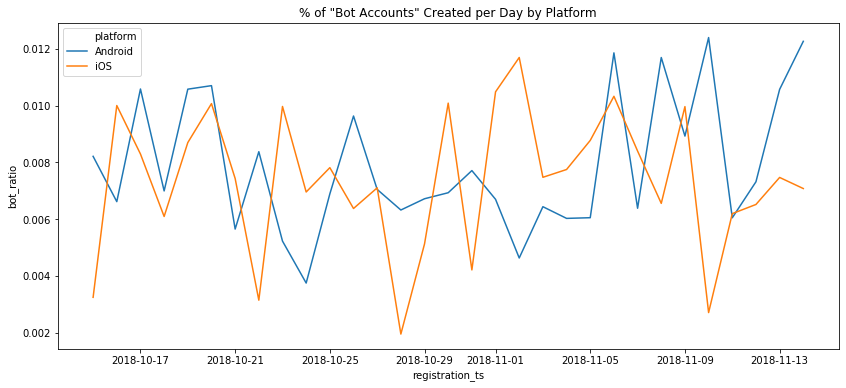

In [33]:
# how many hypothetical "bot" accounts were created per day by platform
bots_by_platform = bots.groupby([bots.registration_ts.dt.date,bots.platform])['user_id'].nunique().reset_index()

# calculate ratio of "bots" / new users
bot_ratio_by_platform = pd.merge(left = bots_by_platform,
                                 right = new_users_by_platform,
                                 on = ['registration_ts','platform'],
                                 how = 'inner')

bot_ratio_by_platform['bot_ratio'] = bot_ratio_by_platform.user_id_x / bot_ratio_by_platform.user_id_y

plt.figure(figsize=(14,6))

sns.lineplot(x = bot_ratio_by_platform['registration_ts'],
             y = bot_ratio_by_platform['bot_ratio'],
             hue = bot_ratio_by_platform['platform']).set(title='% of "Bot Accounts" Created per Day by Platform')

plt.show()

Again, there is no indication of a sudden increase in prevalence of these accounts for the iOS platform, and they are generally just as likely to occur on Android.

<u> Demographic Variables </u>

Below I do a quick scan of some of our descriptive demographic variables to see if there are any unexpected differences in iOS users vs Android users, though no clear differences are revealed at an aggregated level.

In [34]:
# categorical features
    
    # user gender
display(users_final[users_final.platform == 'iOS']['gender'].value_counts(normalize = True))
display(users_final[users_final.platform == 'Android']['gender'].value_counts(normalize = True))

    # metro area
display(users_final[users_final.platform == 'iOS']['metro_area'].value_counts(normalize = True))
display(users_final[users_final.platform == 'Android']['metro_area'].value_counts(normalize = True))

    # age deal-breaker
display(users_final[users_final.platform == 'iOS']['age_strict'].value_counts(normalize = True))
display(users_final[users_final.platform == 'Android']['age_strict'].value_counts(normalize = True))

    # height deal-breaker
display(users_final[users_final.platform == 'iOS']['height_strict'].value_counts(normalize = True))
display(users_final[users_final.platform == 'Android']['height_strict'].value_counts(normalize = True))

    # education attained
display(users_final[users_final.platform == 'iOS']['education_attained'].value_counts(normalize = True))
display(users_final[users_final.platform == 'Android']['education_attained'].value_counts(normalize = True))

0.0    0.58052
1.0    0.41948
Name: gender, dtype: float64

0.0    0.60257
1.0    0.39743
Name: gender, dtype: float64

0     0.236232
39    0.107562
27    0.076294
28    0.059322
6     0.038169
        ...   
61    0.000045
68    0.000022
74    0.000022
75    0.000022
77    0.000022
Name: metro_area, Length: 66, dtype: float64

0     0.235239
39    0.095630
27    0.087495
28    0.051935
6     0.042461
        ...   
67    0.000015
73    0.000015
65    0.000015
75    0.000015
62    0.000015
Name: metro_area, Length: 70, dtype: float64

1.0    0.880136
0.0    0.119864
Name: age_strict, dtype: float64

1.0    0.878891
0.0    0.121109
Name: age_strict, dtype: float64

0.0    0.819764
1.0    0.180236
Name: height_strict, dtype: float64

0.0    0.819939
1.0    0.180061
Name: height_strict, dtype: float64

1.0    0.426436
2.0    0.218433
3.0    0.215219
0.0    0.139912
Name: education_attained, dtype: float64

1.0    0.462959
2.0    0.226363
3.0    0.190520
0.0    0.120157
Name: education_attained, dtype: float64

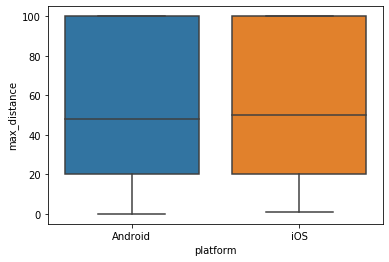

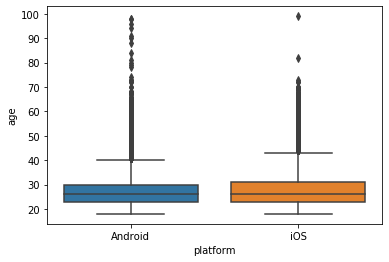

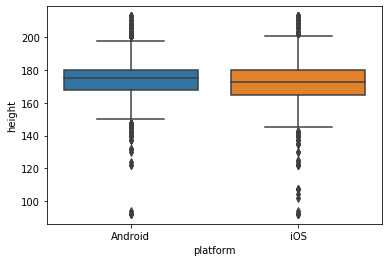

In [35]:
# numerical features

    # max distance
sns.boxplot(x = users_final['platform'],
            y = users_final['max_distance'])
plt.show()

    # user age
sns.boxplot(x = users_final['platform'],
            y = users_final[users_final.age < 100]['age']) # filter outliers
plt.show()

    # user height
sns.boxplot(x = users_final['platform'],
            y = users_final['height'])
plt.show()

#### Experimental Design <a name="q3b"></a>

To conclude, we hypothesize that there may have been some internal/external factor that impacted iOS users differently than Android users starting in November. This is reflected in the iOS decline we observe in our Average Daily Retention Rate plot. One plausible reason for this could be if a new product feature was launched exclusive to Android users which helped keep their retention rate healthy.

If we were to design an experiment to test the validity of this hypothesis, I would suggest performing some A/B testing and rolling out a similar product feature to iOS users to see if it does in fact have the suspected impact. I would go through the following key steps:

1. **Confirm Randomization Unit**: We know we'll need two samples and that the experiment will be run on iOS users.
<br>

2. **Formulate the hypothesis**: The null hypothesis here would be that there is no difference in retention rate between iOS users who get the new product feature and those who don't, while the alternative hypothesis would be that there does exist a difference.

$$
  H_O: {retention}_{control} = {retention}_{treatment}\\
  H_A: {retention}_{control} \neq {retention}_{treatment}
$$

3. **Define statistical parameters**: 

    - We can set a confidence level of 95% meaning our that our critical value `α = 0.05` (industry standard). This just means that if there is truly no effect (i.e., null hypothesis is correct), we can correctly infer there is no effect 95% of the time.
    - We will also set `power = 0.80` (also industry standard). Recall that power is the probability of correctly rejecting the null hypothesis when there is in fact a difference. We want enough power in our experiment to be able to conclude with a high probability whether our experiment has resulted in a significant change.
    - Lastly we can set `MDE = 2%`. The minimum detectable effect is the smallest difference in our metric that would have practical relevance to us. I've pulled this value as there was roughly a 2% difference in the mean retention rate between Android and iOS (`77.1%` vs `75.8%`) in our observed data.
<br>


4. **Determine sample size**: We can run a power analysis to determine our necessary sample size, using the statistical parameters established above

In [36]:
# sample power analysis
import statsmodels.stats.api as sms

required_n = sms.NormalIndPower().solve_power(effect_size = 0.02,
                                              power = 0.8,
                                              alpha = 0.05,
                                              ratio = 1 # for even samples
                                              )
required_n

39244.30254664326

We can see that we'd require `~39,245` for each sampling group.

5. **Set experimentation time**: Would likely set the experiment to run for 3 weeks. This should be long enough to account for day of week effects and primacy/novelty effects.
<br>

6. **Perform statistical testing**: Once the results from our A/B experiment are collected and verified (check there are no violations of SUTVA), we can go forth with our statistical test. Similar to the hypothesis test we performed earlier when validating the hypothetical claim, we'll run a two-sample z-test on our proportions. If our test comes back with a `p-value` less than our significance level `0.05` we'll have enough evidence to reject the null hypothesis and conclude that the new product feature did in fact have an impact on next-day retention rate for our iOS users.